## Project Introduction

<a id="0"></a> <br>
 # Table of Contents  
1. [Introduction](#1)
    1. [Loading Packages](#2) 
1. [Dataset 1](#5)
    1. [EDA](#6) 
1. [Dataset 2](#7)
    1. [EDA](#9)
    1. [Visuals](#8) 
1. [Preprocessing for Modeling](#9) 
1. [Conclusion](#10) 

<a id="1"></a> 
# 1. Introduction

The objective of this Capstone project is to develop a machine learning classifier that can predict whether a product is gluten-free or not based on its product description. The project will leverage a dataset containing product descriptions and their corresponding gluten-free status labels.

<a id="2"></a> 
### 1a. Loading Packages

In [1]:
from collections import Counter
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from textblob import Word
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# Ignore futurewarnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /Users/Amol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Amol/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Amol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<a id="5"></a> 
## 1. Dataset 1

Let's import the dataset which contains 2 columns, one column will correspond to a food item and the second column will state if the iteam is gluten free. (0 for gluten-free and 1 for not-gluten free)

In [4]:
df = pd.read_csv('Gluten-freeDF.csv', encoding='latin1')

In [5]:
# Check
df.head()

,Ingredient,Gluten?
0,2% Milk,0
1,Abies balsamea (Balsam fir) oil,0
2,Abiu,0
3,Acacia Gum,0
4,Açaí Berry,0


The dataset has loaded correctly.

<a id="6"></a> 
#### 1a. Dataset 1 EDA

We can see the Ingredient is uppercase, let's change it into lowercase by applying a string method to the text strings in the 'Ingredient' column.

In [4]:
# Lowercasing all the ingredients
df['Ingredient'] = df['Ingredient'].str.lower()

In [5]:
#Sanity check to ensure all the ingredients are lowercase
df.head()

,Ingredient,Gluten?
0,2% milk,0
1,abies balsamea (balsam fir) oil,0
2,abiu,0
3,acacia gum,0
4,açaí berry,0


The strings have been lowered

For our modeling it is important to check which ingredients contain gluten, so to make the modeling easier let's drop the ingredients that are gluten-free.

In [41]:
# Making a copy of the dataset
df_gluten = df.copy()

# Dataset only contains gluten ingredients
df_gluten = df.loc[df['Gluten?'] == 1]
df_gluten = df_gluten.drop(['Gluten?'], axis=1)

# Redoing the index and dropping the old
df_gluten.reset_index(inplace=True, drop=True)

# Sanity Check
df_gluten.head()

,Ingredient
0,Acetoacetyl Ethyl Amino Acid
1,Alpha-Glucan Oligosaccharide
2,Alpha-Glucan Oligosaccharide Crosspolymer
3,Amino Hydroxypropyl Dimethicone
4,Avena Sativa (Oat) Bran Extract


Now the dataset only contains gluten containing ingredients.

-----

<a id="7"></a> 
## 2. Dataset 2

In [48]:
df2 = pd.read_csv('branded_food.csv')

Exploring the dataset

#### Data Dictionary

1. fdc_id: ID of the food in the food table
2. brand_owner: Brand owner for the food
3. gtin_upc: GTIN or UPC code identifying the food
4. ingredients: The list of ingredients (as it appears on the product label)
5. serving_size: The amount of the serving size when expressed as gram or ml
6. serving_size_unit: The amount of the serving size when expressed as gram or ml
7. household_serving_fulltext: The amount and unit of serving size when expressed in household units
8. branded_food_category: The category of the branded food, assigned by GDSN or Label Insight
9. data_source: The source of the data for this food. GDSN (for GS1) or LI (for Label Insight).
10. modified_date: This date reflects when the product data was last modified by the data provider, i.e., the manufacturer
11. available_date: This is the date when the product record was available for inclusion in the database.
12. discontinued_date: This is the date when the product was discontinued.
13. market_country: The primary country where the product is marketed.

In [49]:
df2.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,27000612323,Vegetable Oil,NaN,15.0,ml,NaN,Oils Edible,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,51000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,51000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,51000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN


The dataset has loaded correctly.

Let's merge another dataset with the current dataset to get product descriptions.

In [50]:
# Loading the new dataset
new_ds = pd.read_csv("food.csv")

# Sanity Check
new_ds.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105898,experimental_food,Discrepancy between the Atwater factor predict...,NaN,2020-10-30


#### Data Dictionary for the New Dataset

1. fdc_id: ID of the food in the food table
2. foodClass: For internal use only
3. data_type: Type of food data (see Files tab for possible values).
4. description: Description of the food
5. food_category_id: Id of the food category the food belongs to
6. publication_date: Date when the food was published to FoodData Central
7. scientific_name: scientific_name
8. food_key: A string of characters used to identify both the current and all historical records for a specific food.

In [51]:
# Shape of the dataset
new_ds.shape

(1913739, 5)

The dataset has 1913739 rows and 5 columns.

Now let's merge the two datasets based on the `fdc_id`.

In [52]:
# Creating the new dataset
df2 = pd.merge(df2, new_ds, on='fdc_id')
df2.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,...,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description,data_type,description,food_category_id,publication_date
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,27000612323,Vegetable Oil,NaN,15.0,ml,NaN,...,2020-11-13,United States,NaN,NaN,NaN,NaN,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,NaN,...,2020-11-13,United States,NaN,NaN,NaN,NaN,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,51000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,NaN,...,2020-11-13,United States,NaN,NaN,NaN,NaN,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,51000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,NaN,...,2020-11-13,United States,NaN,NaN,NaN,NaN,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,51000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,NaN,...,2020-11-13,United States,NaN,NaN,NaN,NaN,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


<a id="9"></a> 
### 2. Dataset 2 EDA

Let's look at the shape of the dataset.

In [53]:
df2.shape

(1845297, 24)

There are 1845297 rows and 24 columns in the dataset.

Lets check if there are any missing values in the dataset.

In [54]:
df2.isna().sum()

fdc_id                               0
brand_owner                      14418
brand_name                      547614
subbrand_name                  1758248
gtin_upc                             0
ingredients                       5393
not_a_significant_source_of    1771801
serving_size                     10780
serving_size_unit                19028
household_serving_fulltext     1079658
branded_food_category            10572
data_source                          0
package_weight                 1139264
modified_date                       20
available_date                       0
market_country                       0
discontinued_date              1845297
preparation_state_code         1806146
trade_channel                  1829718
short_description              1806030
data_type                            0
description                          1
food_category_id               1845297
publication_date                     0
dtype: int64

There are no multiple missing rows in the dataset, lets drop the columns with too many missing rows.

In [55]:
# Droping irreleveant columns
df2 = df2.drop(['discontinued_date','package_weight', 'preparation_state_code', 
                'trade_channel', 'short_description','subbrand_name','not_a_significant_source_of',
                'serving_size', 'serving_size_unit', 'household_serving_fulltext', 'package_weight', 
                'modified_date', 'discontinued_date', 'data_source', 'available_date', "market_country", 
                "food_category_id", "publication_date", "data_type"
               ], axis=1)
df2.head(2)

,fdc_id,brand_owner,brand_name,gtin_upc,ingredients,branded_food_category,description
0,1105904,Richardson Oilseed Products (US) Limited,NaN,27000612323,Vegetable Oil,Oils Edible,WESSON Vegetable Oil 1 GAL
1,1105905,CAMPBELL SOUP COMPANY,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",Herbs/Spices/Extracts,SWANSON BROTH BEEF


The irrelevant columns have been dropped and lets look at the missing values again.

In [56]:
df2.isna().sum()

fdc_id                        0
brand_owner               14418
brand_name               547614
gtin_upc                      0
ingredients                5393
branded_food_category     10572
description                   1
dtype: int64

Let's drop the rows with missing infomation as the dataset is already quite large.

In [57]:
df2 = df2.dropna()

In [58]:
# Sanity Check
df2.isna().sum()

fdc_id                   0
brand_owner              0
brand_name               0
gtin_upc                 0
ingredients              0
branded_food_category    0
description              0
dtype: int64

In [59]:
df2.shape

(1282123, 7)

The dataset has no more missing values

### Case Sensitivity

Because the dataset has a lot of string values let's double check for case sensitivity as it is common in strings. This is dangerous as the same string will be counted as different strings due to different cases. Lets explore in the dataset using `brand_name` as an example. 

Using Honeysuckle White brand as an example.

In [61]:
# Lower Case 
join_ds[join_ds['brand_name'] == 'Honeysuckle White'].shape

(202, 11)

There are 202 rows with the brand "Honeysuckle White"

In [62]:
# Higher case
join_ds[join_ds['brand_name'] == 'HONEYSUCKLE WHITE'].shape

(125, 11)

There are 125 rows with the brand "HONEYSUCKLE WHITE"

In [63]:
# Last case
join_ds[join_ds['brand_name'] == 'honeysuckle white'].shape

(0, 11)

There are 0 rows with the brand "honeysuckle white"

From this we can see all the columns containing strings need to be made the same case. Let's lower the case of `description`, `brand_name`, `brand_owner`, and `branded_food_category`.

In [69]:
# Lowering the case of brand_name
join_ds['brand_name'] = join_ds['brand_name'].str.lower()

# Lowering the case of brand_owner
join_ds['brand_owner'] = join_ds['brand_owner'].str.lower()

# Lowering the case of branded_food_category
join_ds['branded_food_category'] = join_ds['branded_food_category'].str.lower()

# Lowering the case of description
join_ds['description'] = join_ds['description'].str.lower()

# Lowering the case of ingredients
join_ds['description'] = join_ds['ingredients'].str.lower()

In [70]:
# Sanity Check 
join_ds.head()

,fdc_id,brand_owner,brand_name,gtin_upc,ingredients,branded_food_category,market_country,data_type,description,food_category_id,publication_date
0,1847363,cargill incorporated/honeysuckle white,honeysuckle white,642205534517,"All Natural White Turkey, Natural Flavoring",meat/poultry/other animals unprepared/unproce...,United States,branded_food,"all natural white turkey, natural flavoring",NaN,2021-07-29
1,1847364,cargill incorporated/honeysuckle white,honeysuckle white,642205534500,"All Natural Turkey, Natural Flavoing",meat/poultry/other animals unprepared/unproce...,United States,branded_food,"all natural turkey, natural flavoing",NaN,2021-07-29
2,1847365,cargill meat solutions corp.,honeysuckle white,90642205500218,Turkey with up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey with up to 6% absorbed water,NaN,2021-07-29
3,1847366,cargill meat solutions corp.,honeysuckle white,90642205501499,Turkey Wings with up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey wings with up to 6% absorbed water,NaN,2021-07-29
4,1847367,cargill meat solutions corp.,honeysuckle white,90642205501529,Turkey containing up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey containing up to 6% absorbed water,NaN,2021-07-29


In [71]:
# Sanity Check to see if the brand 'honeysuckle white' is being counted correctly
join_ds[join_ds['brand_name'] == 'honeysuckle white'].shape

(327, 11)

From this we can see the case lowering is working and effective

<a id="8"></a> 
### 2a. Dataset 2 Visuals

Lets create bargraphs to see the most common `brand_owner`, `branded_food_category`, and `brand_name`.

##### The first bar graph will be for the top 15 brands.

In [74]:
# Get the top 15 brands by count
top_15_brands = join_ds['brand_name'].value_counts()[:15].index.tolist()

# Filter the DataFrame to include only the top 15 brands
top_15_brands_df = join_ds[join_ds['brand_name'].isin(top_15_brands)]

# Create a new DataFrame to store brand counts
brand_counts = top_15_brands_df['brand_name'].value_counts().reset_index()
brand_counts.columns = ['brand_name', 'count']

brand_counts.head(2)

,brand_name,count
0,great value,20508
1,meijer,18502


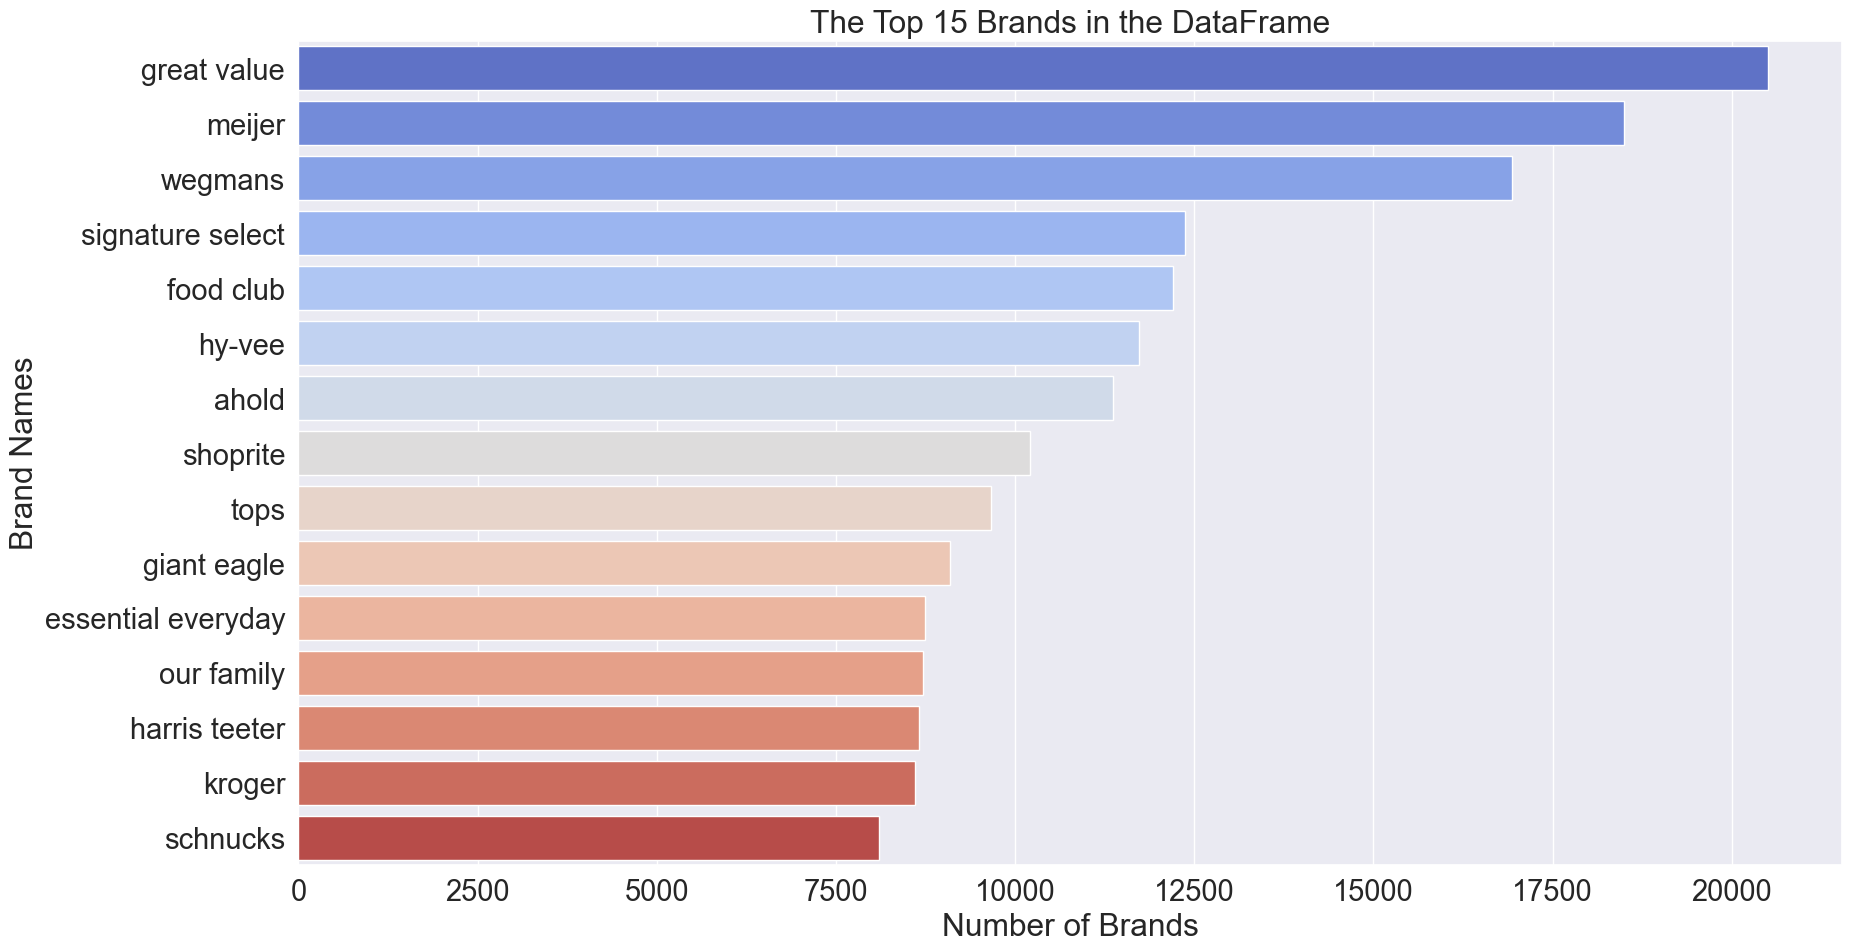

In [75]:
sns.set(font_scale=1.9)
plt.figure(figsize=(19, 10))
sns.barplot(y='brand_name', x='count', data=brand_counts, palette='coolwarm')
plt.xlabel("Number of Brands")
plt.ylabel("Brand Names")
plt.title("The Top 15 Brands in the DataFrame")
plt.tight_layout()
plt.show()

We can see the top brand is Great Value, Meijer and Wegmans.

##### Let's create a graph to see the 10 most common `branded_food_category`

In [76]:
# Get the top 20 category by count
top_10_category= join_ds['branded_food_category'].value_counts()[:10].index.tolist()

# Filter the DataFrame to include only the top 20 food category
top_10_category_df = join_ds[join_ds['branded_food_category'].isin(top_10_category)]

# Create a new DataFrame to store category counts
category_counts = top_10_category_df['branded_food_category'].value_counts().reset_index()
category_counts.columns = ['branded_food_category', 'count']

category_counts.shape

(10, 2)

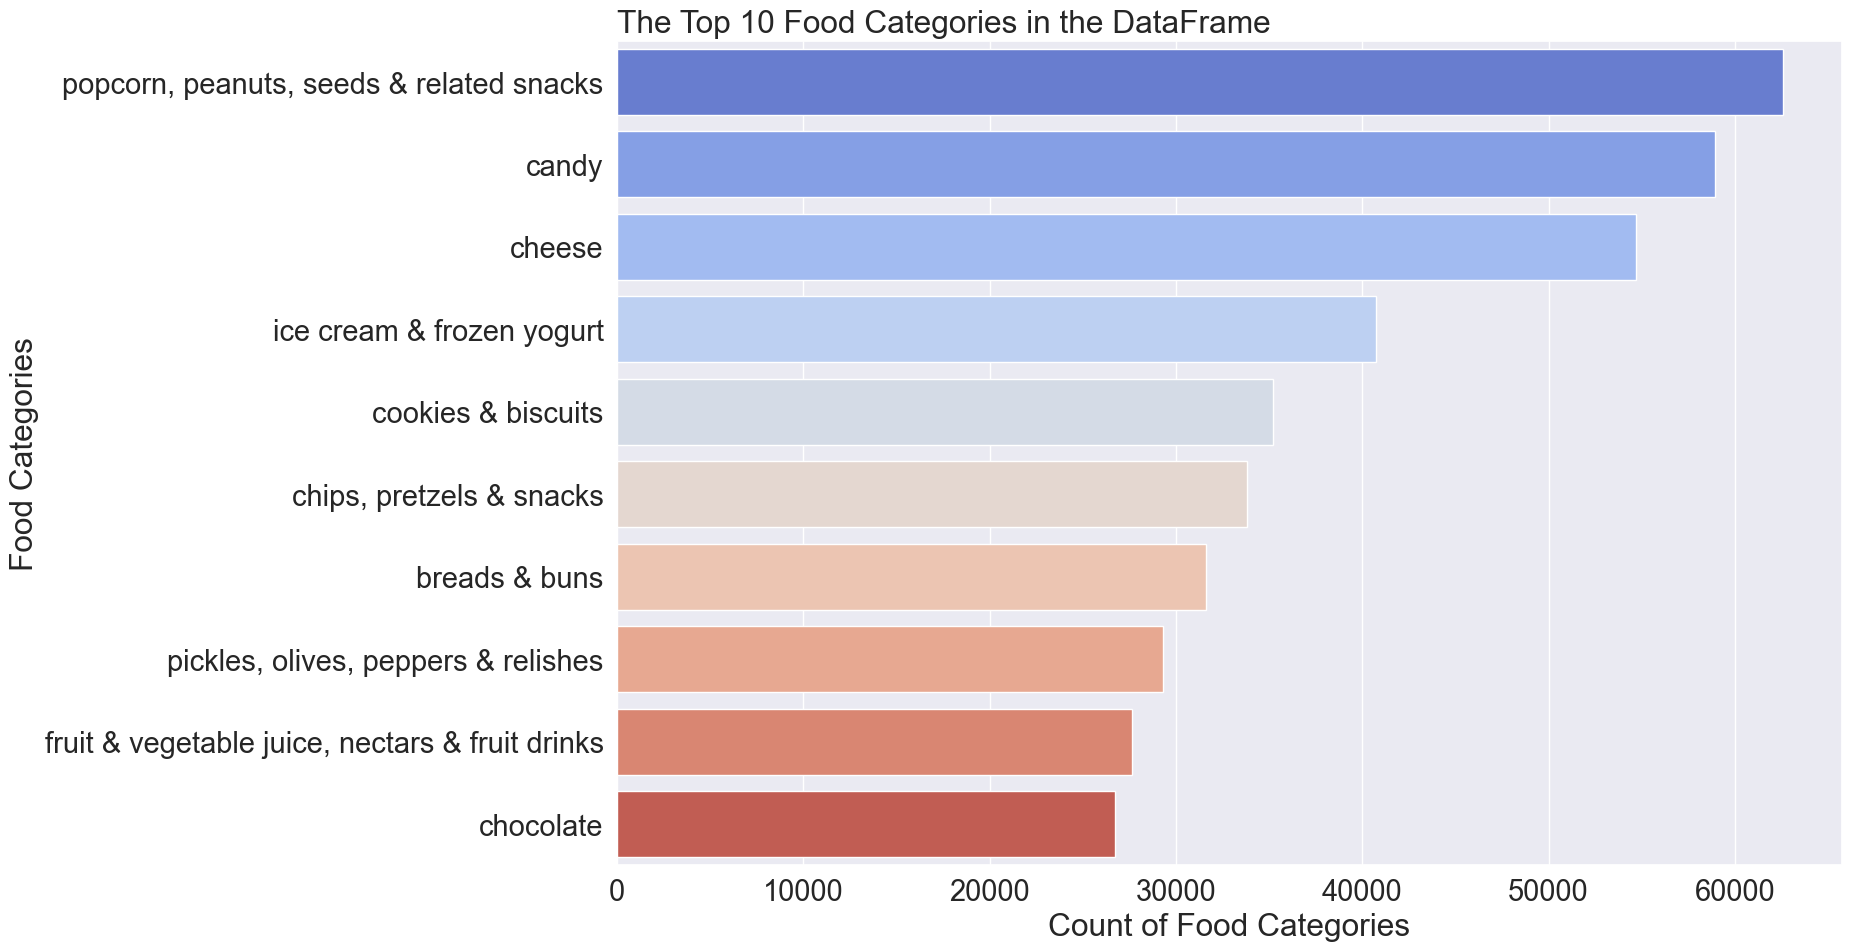

In [77]:
sns.set(font_scale=1.9)
plt.figure(figsize=(19, 10))
sns.barplot(y='branded_food_category', x='count', data=category_counts, palette='coolwarm')
plt.xlabel("Count of Food Categories")
plt.ylabel("Food Categories", loc='center')
plt.title("The Top 10 Food Categories in the DataFrame", loc='left')
plt.tight_layout()
plt.show()

We can see the top food categories are Popcorn,Peanuts,Seeds, & Realted Snacks, Candy, and Cheese.

##### Let's create a graph to see the 10 most common `brand_owner`

In [78]:
# Get the top 20 owner by count
top_10_owner= join_ds['brand_owner'].value_counts()[:10].index.tolist()

# Filter the DataFrame to include only the top 20 food owner
top_10_owner_df = join_ds[join_ds['brand_owner'].isin(top_10_owner)]

# Create a new DataFrame to store owner counts
owner_counts = top_10_owner_df['brand_owner'].value_counts().reset_index()
owner_counts.columns = ['brand_owner', 'count']

owner_counts.shape

(10, 2)

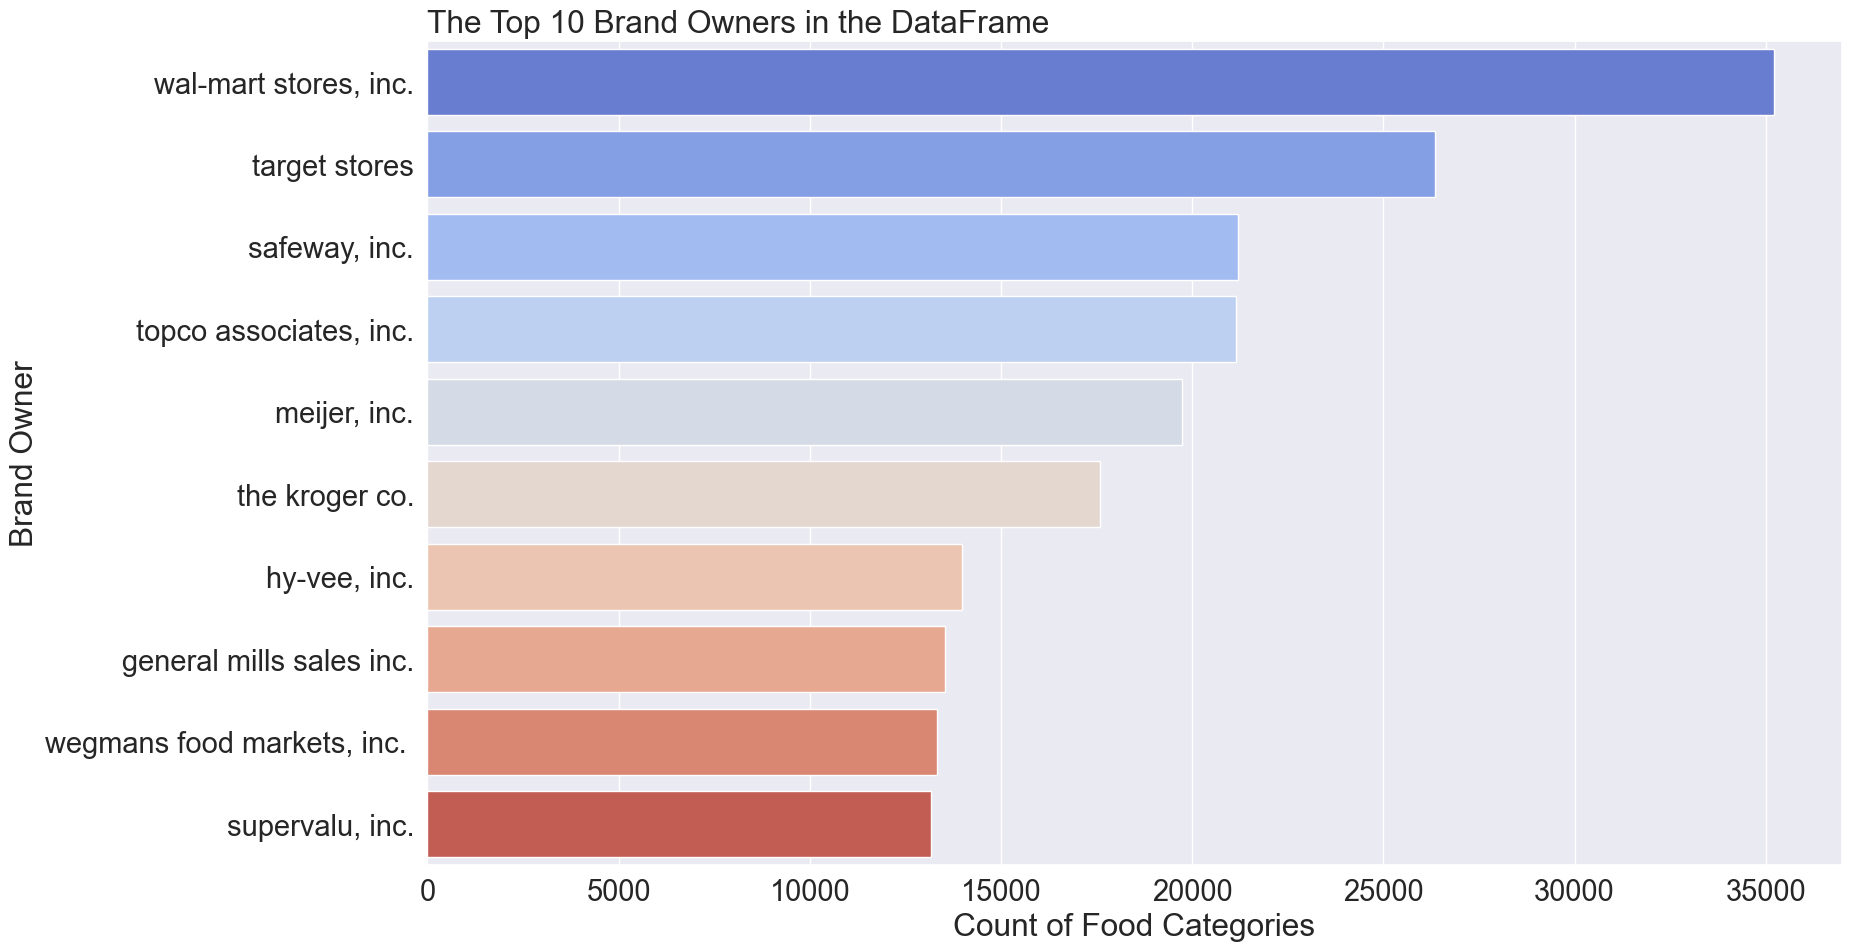

In [79]:
sns.set(font_scale=1.9)
plt.figure(figsize=(19, 10))
sns.barplot(y='brand_owner', x='count', data=owner_counts, palette='coolwarm')
plt.xlabel("Count of Food Categories")
plt.ylabel("Brand Owner", loc='center')
plt.title("The Top 10 Brand Owners in the DataFrame", loc='left')
plt.tight_layout()
plt.show()

We can see the top brand owners are Wal-mart Stores, Target, and Safeway.


-------

-----

<a id="9"></a> 
# Preprocessing

For the modeling we will need to create a new column to indicate if the product is gluten free based on the ingredient list and the dataset of gluten containing ingredients.

#### Function called my_tokenizer

First lets create a function that takes a string containing a list of ingredients as input. It processes this input list to tokenize and clean it.

1. sentence = sentence.replace('-', ' ').lower(): This line replaces hyphens with spaces and converts the entire list of ingredients to lowercase.

2. listofwords = re.split(r'[,\(\)\[\]]', sentence): This line splits the list of ingredients into a list of words. It splits the list at commas, parentheses, square brackets, and round brackets. This step essentially separates the ingredients into individual words and removes the listed punctuation.

3. listofprocessed_words = []: Initializes an empty list to store the processed words.

4. word = word.strip(): Removes leading and trailing whitespace from the word.

5. if word != '' and '.' not in word and 'ingredient' not in word:: Checks if the word is not empty, does not contain a period (.), and does not contain the substring 'ingredient'.

6. singular_word = wordnet.morphy(word): Tries to find the singular form of the word. If a singular form is found, it's added to listofprocessed_words. If not, the original word is added.

7. Finally, the function returns listofprocessed_words, which is a list of cleaned and tokenized words extracted from the input list of ingredients with hyphens removed, in lowercase, and with some common words like "ingredient" filtered out.

In [81]:
def my_tokenizer(sentence):
    # Remove hyphens and set to lowercase
    sentence = sentence.replace('-', ' ').lower()

    # Tokenize sentence into words
    listofwords = re.split(r'[,\(\)\[\]]', sentence)
    listofprocessed_words = []

    # Remove empty strings and leading/trailing whitespace
    for word in listofwords:
        word = word.strip()
        if word != '' and '.' not in word and 'ingredient' not in word:
            singular_word = wordnet.morphy(word)
            if singular_word:
                listofprocessed_words.append(singular_word)
            else:
                listofprocessed_words.append(word)

    return listofprocessed_words 

In [82]:
# Sanity Check
input_ingredient_list = "GLUTEN FREE FLOUR (TAPIOCA STARCH, WHITE RICE FLOUR, SORGHUM FLOUR, CORN STARCH), PALM OIL, WATER, EGGS, SUGAR, SALT, XANTHAN GUM, CHERRY FILLING (CHERRIES, WATER, SUGAR, CORN SYRUP, MODIFIED FOOD STARCH, VEGETABLE GUM, CITRIC ACID, VEGETABLE EXTRACT)."
preprocessed_tokens = my_tokenizer(input_ingredient_list)
print(preprocessed_tokens)

['gluten free flour', 'tapioca starch', 'white rice flour', 'sorghum flour', 'corn starch', 'palm oil', 'water', 'eggs', 'sugar', 'salt', 'xanthan gum', 'cherry filling', 'cherry', 'water', 'sugar', 'corn syrup', 'modified food starch', 'vegetable gum', 'citric acid', 'vegetable extract']


From the sanity check we can see the function works.

#### Function called is_gluten_free

The is_gluten_free function is designed to check whether a list of ingredients is gluten-free or not. It does this by comparing the ingredients in the input list to a list of gluten-containing ingredients stored in a dataset named df_gluten. Here's how the function works:

1. my_tokenizer(lst): Using my_tokenizer function to tokenize and clean the input list of ingredients lst. This step converts the input list into a list of processed words following the rules specified in the my_tokenizer function.

2. token in list(df_gluten['Ingredient']): This part of the code checks if any of the processed words in the input list of ingredients are present in the 'Ingredient' column of the df_gluten dataset.

3. if any(...): The any function is used to check if at least one ingredient in the input list matches an ingredient in the gluten list. If any match is found, it means that the input list contains a gluten-containing ingredient, and the function returns 0, indicating that it's not gluten-free.

4. Else the function returns 1, indicating that the input list is gluten-free.

In [83]:
def is_gluten_free(lst):
    # Checking if any ingredient in the input list is the same as an ingredient in the gluten list.
    if any(token in list(df_gluten['Ingredient']) for token in my_tokenizer(lst)):
        return 0  # Not gluten-free
    else:
        return 1  # Gluten-free

Let's check if the function works by creating a list containing gluten ingredients

In [48]:
is_gluten_free(input_ingredient_list)

1

The function correctly classified the list as gluten free

In [49]:
# Example for not gluten-free

input_ingredient_list_nogf = "FLOUR (Wheat flour, WHITE RICE FLOUR, SORGHUM FLOUR, CORN STARCH), PALM OIL,)"

is_gluten_free(input_ingredient_list_nogf)

0

The function correctly classified the list as not gluten free

The fuction is working at classify correctly.

#### Adding the new column to the dataset

Adding a new column in the dataset to indicate if a product is gluten-free based on the `my_tokenizer` and `is_gluten_free` functions made above.

In [85]:
# The function is applied to the entire dataset based on the ingredient column
join_ds["gluten_free?"] = join_ds['ingredients'].apply(is_gluten_free)

In [87]:
join_ds.head()

,fdc_id,brand_owner,brand_name,gtin_upc,ingredients,branded_food_category,market_country,data_type,description,food_category_id,publication_date,gluten_free?
0,1847363,cargill incorporated/honeysuckle white,honeysuckle white,642205534517,"All Natural White Turkey, Natural Flavoring",meat/poultry/other animals unprepared/unproce...,United States,branded_food,"all natural white turkey, natural flavoring",NaN,2021-07-29,1
1,1847364,cargill incorporated/honeysuckle white,honeysuckle white,642205534500,"All Natural Turkey, Natural Flavoing",meat/poultry/other animals unprepared/unproce...,United States,branded_food,"all natural turkey, natural flavoing",NaN,2021-07-29,1
2,1847365,cargill meat solutions corp.,honeysuckle white,90642205500218,Turkey with up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey with up to 6% absorbed water,NaN,2021-07-29,1
3,1847366,cargill meat solutions corp.,honeysuckle white,90642205501499,Turkey Wings with up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey wings with up to 6% absorbed water,NaN,2021-07-29,1
4,1847367,cargill meat solutions corp.,honeysuckle white,90642205501529,Turkey containing up to 6% absorbed water,meat/poultry/other animals unprepared/unproce...,United States,branded_food,turkey containing up to 6% absorbed water,NaN,2021-07-29,1


<a id="10"></a> 
# Conclusion

##### Lets export the dataset to run in another python file

In [ ]:
# Lets only take the description and gluten_free? column as they are only reqired for the modeling
dataset = join_ds[['description', 'gluten_free?']].copy()

In [74]:
dataset.to_csv('Capstone.csv', index=False)